此程式用來便歷指定資料夾內所有軸承的運轉力矩條件，以確認EVCC實驗結果異常是由何處導致

In [52]:
# import used functioons 
#  import tools 
%matplotlib inline

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

# -*- coding: utf-8 -*-
import os
import re
from pathlib import Path
from collections import defaultdict, OrderedDict

import matplotlib.pyplot as plt

# -*- coding: utf-8 -*-
from pathlib import Path
from collections import defaultdict, OrderedDict
from typing import Optional
import matplotlib.pyplot as plt



# ===================== 你自己的 torque 函式 =====================
# ❗請改成你的實作
def get_torque(file_path: str) -> float:
    # 讀取資料
    df = read_rul_data(file_path, force_recompute=False)
    
    if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1:
        # 檢測極性校正是否失效
        print(f"File {file_path} has high THD, skipping.")
        torque=None
        return torque
        
    current_alpha = np.array(df["Current alpha downsample"])
    current_beta = np.array(df["Current beta downsample"])
    flux_alpha = np.array(df["Flux alpha"])
    flux_beta = np.array(df["Flux beta"])
    
    # emf_alpha = (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
    # emf_beta = (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
    
    # torque_airgap = 1.5 * 4 * (flux_alpha * current_beta - flux_beta * current_alpha)  # 計算torque
        
    torque = (df["Torque avg"]) 
    return torque
# ============================================================

# 工況名稱擷取：抓 rpm, V, N
COND_REGEX = re.compile(r"(?P<rpm>\d+)\s+(?P<volt>\d+(?:\.\d+)?)V\s+(?P<load>\d+(?:\.\d+)?)N")

def parse_condition_from_dirname(name: str):
    m = COND_REGEX.search(name)
    if not m:
        return None
    return (int(m.group("rpm")), float(m.group("volt")), float(m.group("load")))

def collect_torque_by_condition(root: Path, state_filter: Optional[str] = None):
    """
    return:
        cond_key -> bearing_state -> [torques...]
    cond_key = (rpm, volt, load)
    """
    data = defaultdict(lambda: defaultdict(list))

    for bearing_state_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        bearing_label = bearing_state_dir.name
        if state_filter and state_filter not in bearing_label:
            continue

        for cond_dir in sorted([p for p in bearing_state_dir.iterdir() if p.is_dir()]):
            cond_tuple = parse_condition_from_dirname(cond_dir.name)
            if not cond_tuple:
                continue

            parquet_files = list(cond_dir.glob("*.parquet"))
            if not parquet_files:
                continue

            for f in parquet_files:
                try:
                    torque = get_torque(str(f))
                    if torque is not None:
                        data[cond_tuple][bearing_label].append(float(torque))
                except Exception as e:
                    print(f"[WARN] get_torque failed: {f} -> {e}")
    return data

def _order_conditions_for_grid(conditions):
    return sorted(conditions, key=lambda x: (x[0], x[1], x[2]))

def plot_3x3_torque(data, title=None, conditions=None):
    all_conditions = _order_conditions_for_grid(list(data.keys())) if conditions is None else conditions
    conditions = all_conditions[:9]
    n = len(conditions)
    rows = cols = 3

    # constrained_layout 自動處理邊界空間
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), constrained_layout=True)
    axes = axes.flatten()

    all_bearings = OrderedDict()
    for cond in conditions:
        for b in data[cond].keys():
            all_bearings.setdefault(b, None)

    markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*", "h", "H", "d", "p"]
    bearing_marker = {b: markers[i % len(markers)] for i, b in enumerate(all_bearings.keys())}

    # 繪製每個子圖
    for i, cond in enumerate(conditions):
        ax = axes[i]
        rpm, volt, load = cond

        for b_idx, (bearing_label, torques) in enumerate(sorted(data[cond].items(), key=lambda x: x[0])):
            xs = [j + b_idx * 0.08 for j in range(len(torques))]
            ax.scatter(xs, torques, label=bearing_label if i == 0 else None,
                       marker=bearing_marker[bearing_label])

        ax.set_title(f"{rpm} rpm, {volt} V, {load} N")
        ax.set_xlabel("Sample index")
        ax.set_ylabel("Torque")
        ax.grid(True, linestyle=":", linewidth=0.8)

    # 移除多餘子圖
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    # 圖例：放在子圖區域正下方，由 constrained_layout 安排排版
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles,
            labels,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.01),
            ncol=min(5, len(labels)),
            frameon=False,
        )

    # 標題也交由 constrained_layout 智慧調整
    if title:
        fig.suptitle(title, fontsize=16)

    plt.show()

def plot_3x3_pages(data, title_prefix="Torque Comparison", per_page=9):
    ordered = _order_conditions_for_grid(list(data.keys()))
    pages = []
    for i in range(0, len(ordered), per_page):
        page_conds = ordered[i:i+per_page]
        page_no = i // per_page + 1
        plot_3x3_torque(data,
                        title=f"{title_prefix} — Page {page_no}",
                        conditions=page_conds)
        pages.append(page_conds)
    return pages


def _order_conditions_for_grid(conditions):
    return sorted(conditions, key=lambda x: (x[0], x[1], x[2]))

def plot_3x3_torque_states_on_x_nojitter(
    data,
    title=None,
    conditions=None,
    xtick_rotation=30,
    alpha=0.5,
    show_mean=False,
    show_median=False,
    pad_ratio=0.1,          # 每張子圖自己的上下留白比例
):
    """
    每張子圖：
      X 軸 = 軸承狀態（分類，單一座標）
      Y 軸 = 該狀態所有 torque 散點（無抖動，同一 x）
    data: dict[(rpm, volt, load)] -> dict[bearing_state] -> list[torque]
    """
    # 取要畫的 9 個工況
    all_conditions = _order_conditions_for_grid(list(data.keys())) if conditions is None else conditions
    conditions = all_conditions[:9]
    n = len(conditions)
    rows = cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), constrained_layout=True)
    axes = axes.flatten()

    for i, cond in enumerate(conditions):
        ax = axes[i]
        rpm, volt, load = cond

        # 固定軸承狀態順序
        bearing_states = sorted(list(data[cond].keys()))
        x_positions = np.arange(len(bearing_states))

        # 先蒐集當前工況的所有 torque，供本子圖計算 ylim
        vals_this_cond = []
        for b_state in bearing_states:
            vals_this_cond.extend(data[cond][b_state])

        # 若沒有值就跳過
        if not vals_this_cond:
            ax.set_title(f"{rpm} rpm, {volt} V, {load} N (no data)")
            ax.axis("off")
            continue

        # 畫散點
        for x_idx, b_state in enumerate(bearing_states):
            torques = data[cond][b_state]
            if not torques:
                continue
            xs = np.full(len(torques), x_positions[x_idx])  # 單一 X 座標
            ys = torques
            ax.scatter(xs, ys, s=18, alpha=alpha)

            # 選配：平均線/中位數
            if show_mean:
                m = float(np.mean(ys))
                ax.hlines(m, x_positions[x_idx]-0.25, x_positions[x_idx]+0.25,
                          linestyles="--", linewidth=1)
            if show_median:
                med = float(np.median(ys))
                ax.hlines(med, x_positions[x_idx]-0.25, x_positions[x_idx]+0.25,
                          linestyles="-.", linewidth=1)

        # 這裡改成「每個工況各自的 ylim」
        y_min, y_max = min(vals_this_cond), max(vals_this_cond)
        span = (y_max - y_min)
        # fallback：若全相等，給一個合理的高度避免扁平
        pad = pad_ratio * span if span > 0 else max(abs(y_max), 1.0) * pad_ratio
        ax.set_ylim(y_min - pad, y_max + pad)

        ax.set_title(f"{rpm} rpm, {volt} V, {load} N")
        ax.set_ylabel("Torque")
        ax.set_xlabel("Bearing state")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(bearing_states, rotation=xtick_rotation, ha="right")
        ax.grid(True, linestyle=":", linewidth=0.8)

    # 補齊不足 9 的子圖
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    if title:
        fig.suptitle(title, fontsize=16)

    plt.show()

 

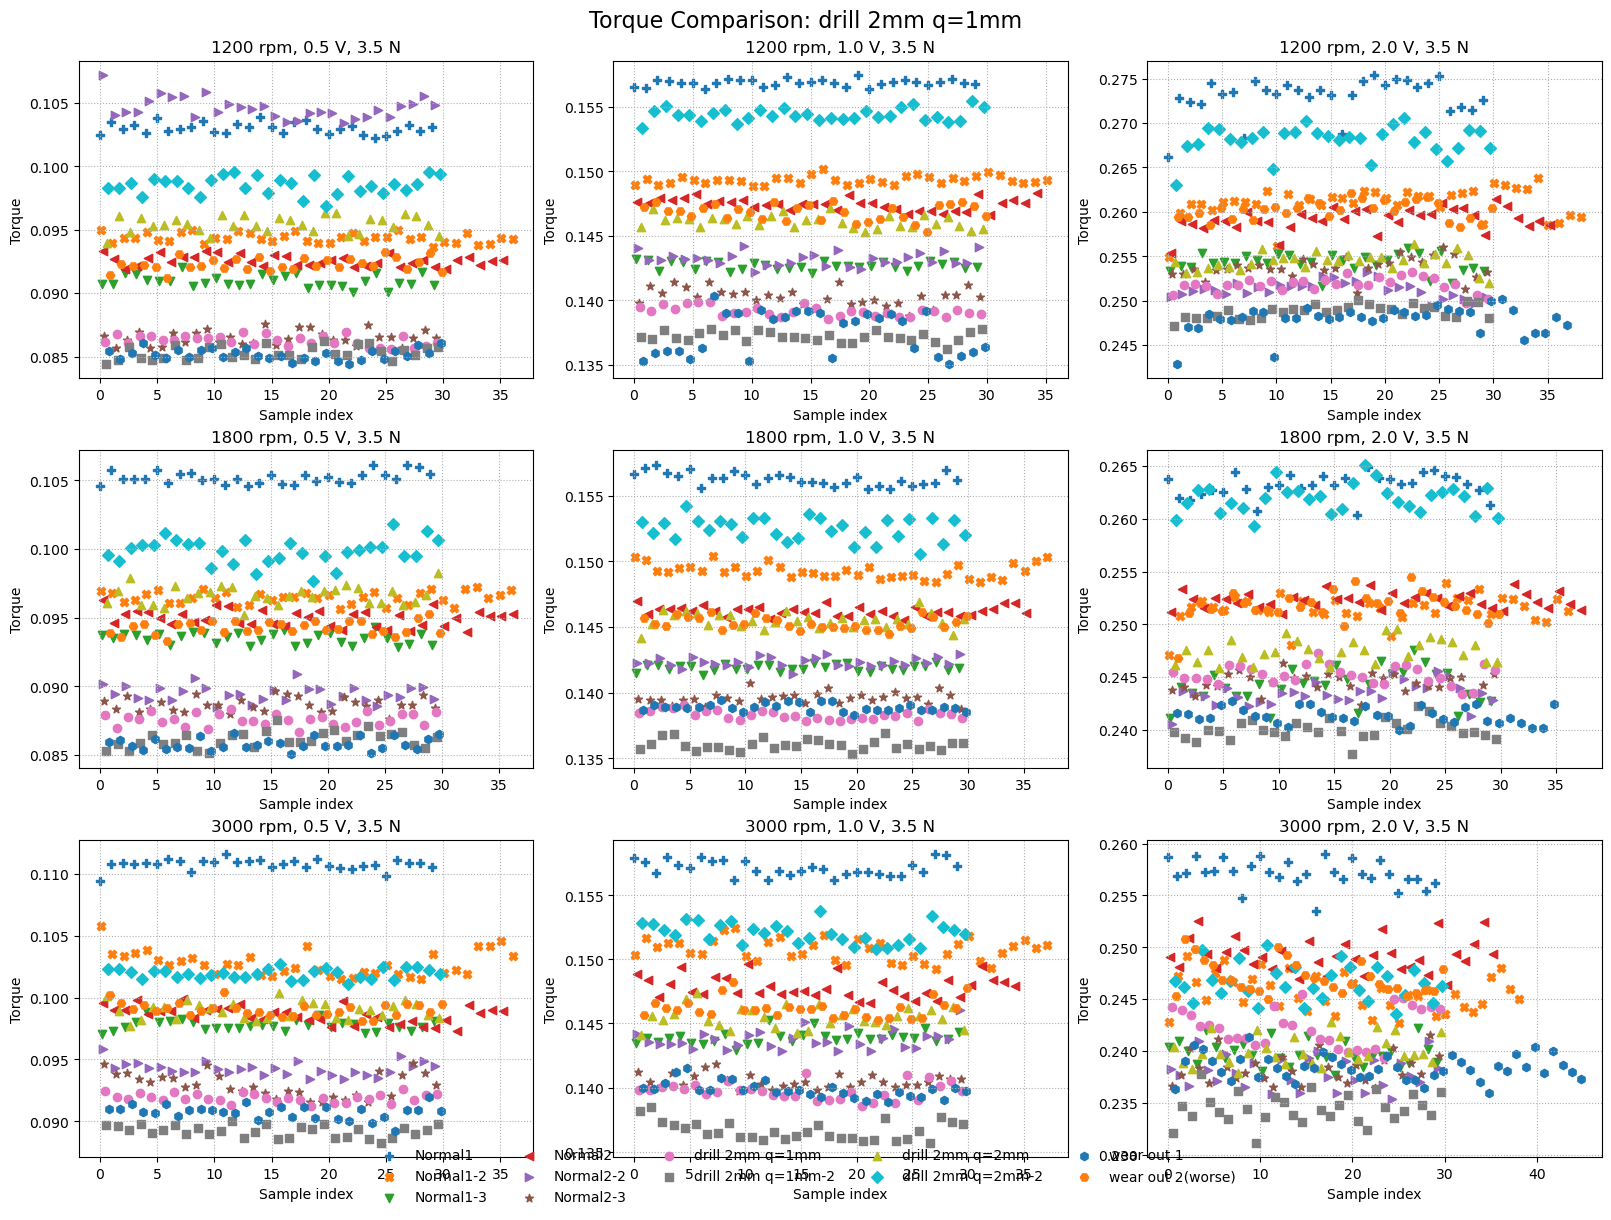

In [50]:
root = Path("D:\OneDrive\CCAE_experiments\CCAE_datasets5-2")
# state_filter = "drill 2mm q=1mm"  # 只分析特定軸承狀態
state_filter = None  # 只分析特定軸承狀態

data = collect_torque_by_condition(root, state_filter)
plot_3x3_torque(data, title="Torque Comparison: drill 2mm q=1mm")


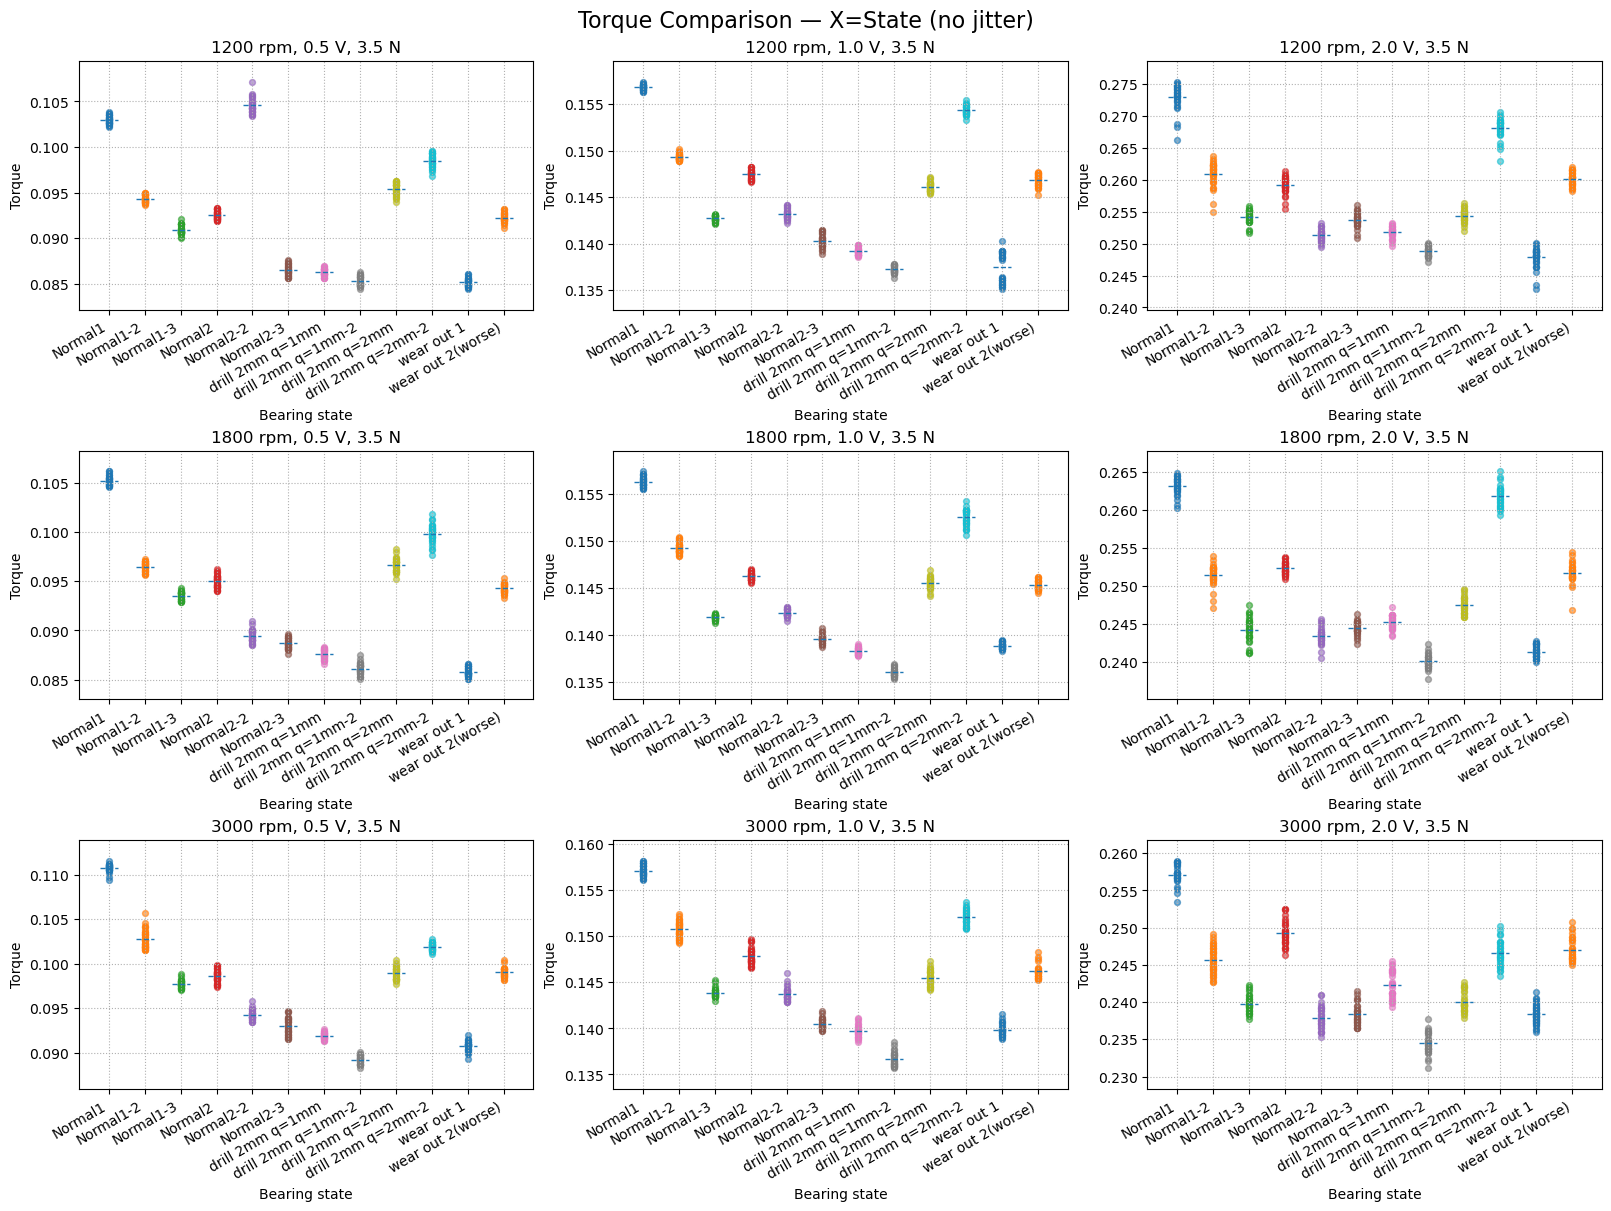

In [53]:
# 假設你已有 data
# data = collect_torque_by_condition(root)

plot_3x3_torque_states_on_x_nojitter(
    data,
    title="Torque Comparison — X=State (no jitter)",
    xtick_rotation=30,
    alpha=0.6,
    show_mean=True,      # 想看平均線就 True
    show_median=False    # 想看中位數線就 True
)
